# REGRESSION FORECAST USING SKLEARN

In [1]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt 
import seaborn as sns
sns.set_theme()
sns.set(rc={'figure.figsize':(9, 5)})

from sklearn.linear_model import LinearRegression

I' ll use the `penguins` dataset from the `seaborn` package to predict the `sex` of the penguin based on some other features in the data. 

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [3]:
df = sns.load_dataset('penguins')
df = df[~pd.isna(df.flipper_length_mm)]
df['target'] = [1 if el == 'Male' else 0 for el in df['sex']]
df.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,target
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male,1
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female,0
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female,0
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female,0
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,Male,1


#### Exploratory Data Analysis

Let's see how the different metrics are distributed according to the species of the animal as well as the target variable (here transformed to a binary indicator where Male = 1):

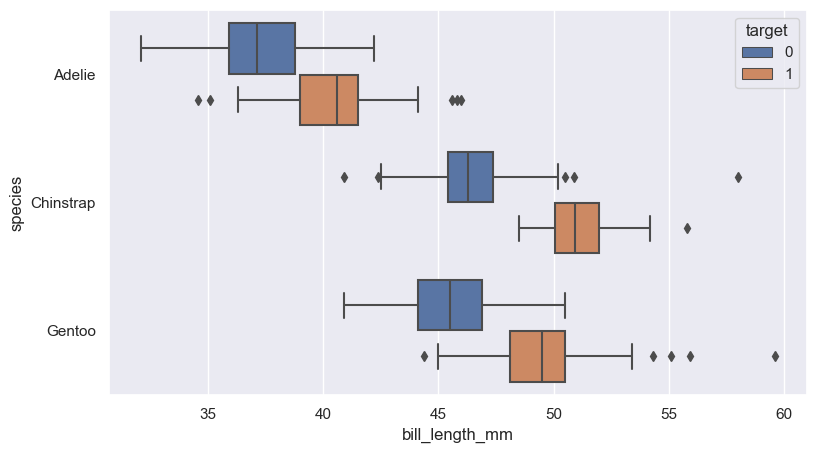

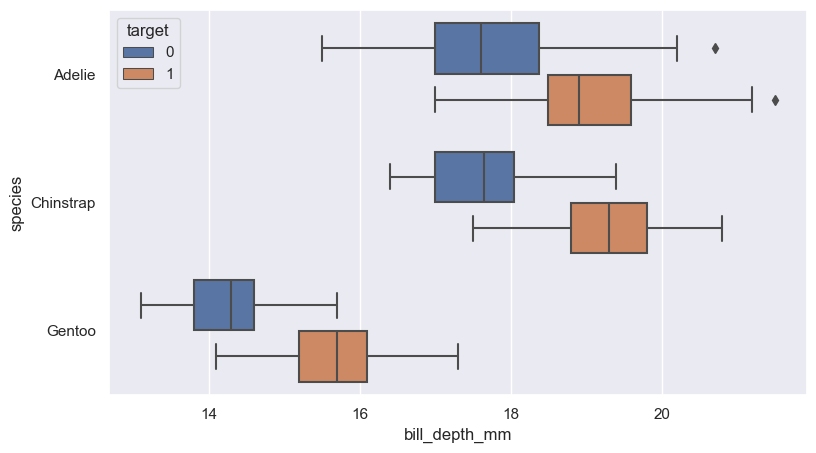

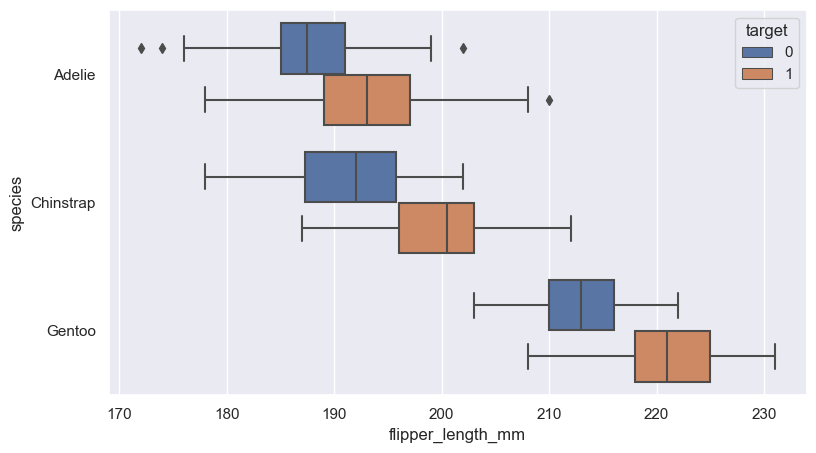

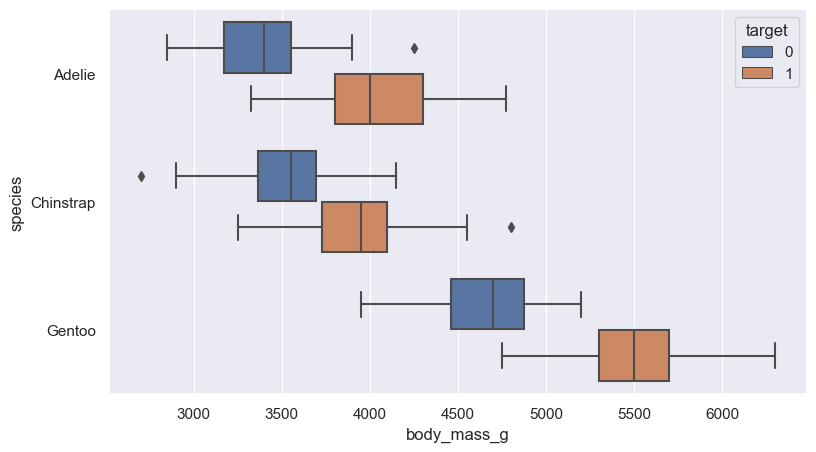

In [4]:
for feature in ['bill_length_mm','bill_depth_mm','flipper_length_mm','body_mass_g']: 
    sns.boxplot(x=feature, y='species', hue='target', data = df)
    plt.show()

#### Dummy Variables

Since `species` is a **categorical variable**, is crucial to convert this variable in dummy variables, because of multicollinearity.

In [6]:
df2 = pd.get_dummies(df, columns=["species"])
df2 = df2[['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm','body_mass_g','target',
           'species_Adelie','species_Chinstrap','species_Gentoo']]
df2.head()

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,target,species_Adelie,species_Chinstrap,species_Gentoo
0,39.1,18.7,181.0,3750.0,1,1,0,0
1,39.5,17.4,186.0,3800.0,0,1,0,0
2,40.3,18.0,195.0,3250.0,0,1,0,0
4,36.7,19.3,193.0,3450.0,0,1,0,0
5,39.3,20.6,190.0,3650.0,1,1,0,0


In [7]:
df2[['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm','body_mass_g']].corr()

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g
bill_length_mm,1.000000,-0.235053,0.656181,0.595110
bill_depth_mm,-0.235053,1.000000,-0.583851,-0.471916
flipper_length_mm,0.656181,-0.583851,1.000000,0.871202
body_mass_g,0.595110,-0.471916,0.871202,1.000000


#### Multicollinearity

**Multicollinearity** among the predictors is an issue in Logistic regression, therefore I have done a preliminary check on the variables, especially on the numeric ones and find that `flipper_length_mm` and `body_mass_g` are **highly correlated**, so it would be best to choose either one or the other.`body_mass_g` appears to be less correlated with the other features. 

#### Model Definition

Starting from the predictors matrix $X$ and the target vector $y$, I split the dataset in **70% for training** and **30% for testing**, then **define the model** and **fit it to the data**, obtaining the **estimates of the regression coefficients**. 

In [8]:
y = df2['target']
X = df2[['body_mass_g','bill_length_mm','bill_depth_mm','species_Adelie','species_Chinstrap']]

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [10]:
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [11]:
print('Intercept:', log_reg.intercept_)
print('Coefficients:', log_reg.coef_[0])

Intercept: [-63.97839325]
Coefficients: [ 0.00488219  0.25560207  1.83899522  1.87261939 -0.82956335]


#### Model Evaluation

I' ll use these predictions to assess the performance of the model using a **confusion matri**

In [12]:
y_pred = log_reg.predict(X_test)

In [13]:
# accuracy of predictions:
np.mean(y_pred==y_test)

0.912621359223301

In [14]:
cm = metrics.confusion_matrix(y_test, y_pred)
cm

array([[48,  3],
       [ 6, 46]], dtype=int64)

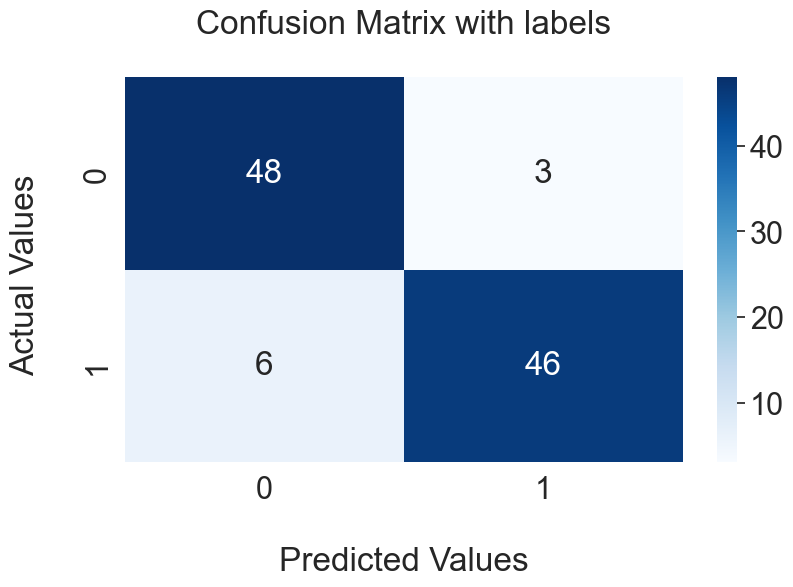

In [15]:
# visualization of the Confusion Matrix
sns.set(font_scale=2)

ax = sns.heatmap(cm, annot=True, cmap='Blues')

ax.set_title('Confusion Matrix with labels\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values \n');

ax.yaxis.set_ticklabels(['0','1'])
ax.xaxis.set_ticklabels(['0','1'])

plt.show()

In [16]:
metrics.accuracy_score(y_test, y_pred)

0.912621359223301

In [17]:
metrics.precision_score(y_test, y_pred)

0.9387755102040817

In [18]:
metrics.recall_score(y_test, y_pred)

0.8846153846153846

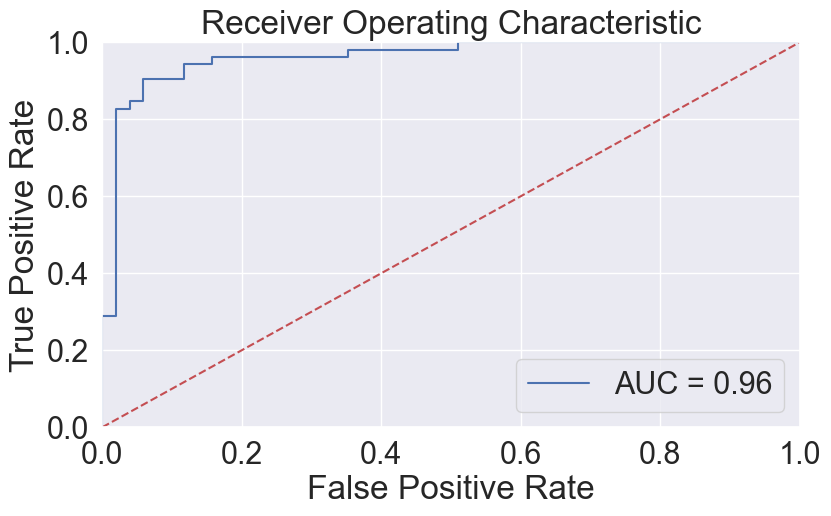

In [19]:
# calculate the fpr and tpr for all thresholds of the classification
probs = log_reg.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

# plot the ROC curve and print the AUC
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()